### Melenoma Detection using deep learning

#### <font color= Purple>Problem Statement:</font>
`Context`:
Skin cancer, particularly melanoma, is a significant public health concern due to its potential lethality if not detected early. Dermatologists rely on visual examination of skin lesions to diagnose melanoma, but this process can be time-consuming and subjective. Therefore, the development of a reliable and accurate automated system for melanoma detection using machine learning techniques is highly desirable. Here we use CNN model to classify various skin diseases to detect melanoma.

`Objective`:
The objective of this project is to build a convolutional neural network (CNN) model capable of accurately detecting melanoma and other skin diseases from images. The model will be trained on a dataset containing images of various skin diseases, including melanoma, and will classify the images into one of the nine disease categories. The ultimate goal is to develop a robust and effective tool that can assist dermatologists in diagnosing skin diseases more efficiently.

`Data Overview`:
The dataset consists of 2,357 images of malignant and benign skin diseases, sourced from the International Skin Imaging Collaboration (ISIC). These images are categorized into nine classes, including melanoma, nevus, squamous cell carcinoma, and others. Each image has been labeled according to its corresponding disease category.The data set contains the following diseases:Actinic keratosis, Basal cell carcinoma, Dermatofibroma, Melanoma, Nevus, Pigmented benign keratosis, Seborrheic keratosis, Squamous cell carcinoma, and Vascular lesion.


The notebook contains the following contents:

- Data reading/understanding
- Data creation
- Data Visualisation
- Model building & training- 1st attempt
- Data augmentation to resolve overfitting
- Model building & training on augmented data - 2nd attempt
- Class Distribution
- Handling class imbalance
- Final Model building & training
- Model testing

### Data reading/understanding:

#### Importing the Skin cancer ISIC The International Skin Imaging Collaboration dataset

In [1]:
## Importing the neccessary libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout,BatchNormalization
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Deep learning/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Deep learning/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [4]:
# Counting the number of images in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2249
118


## Dataset Creation

We will load the datasets using keras.preprocessing and split the dataset for training and validation


In [5]:
## Defining parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

#### Sliptting the dataset: 80% for training and 20% for validation

In [6]:
# Training dataset
# Create a training dataset by loading images from the specified directory using TensorFlow's image_dataset_from_directory function
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


In [7]:
# Testing dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2249 files belonging to 9 classes.
Using 449 files for validation.


In [7]:
## Listing the classes of skin cancer
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Data Visualisation

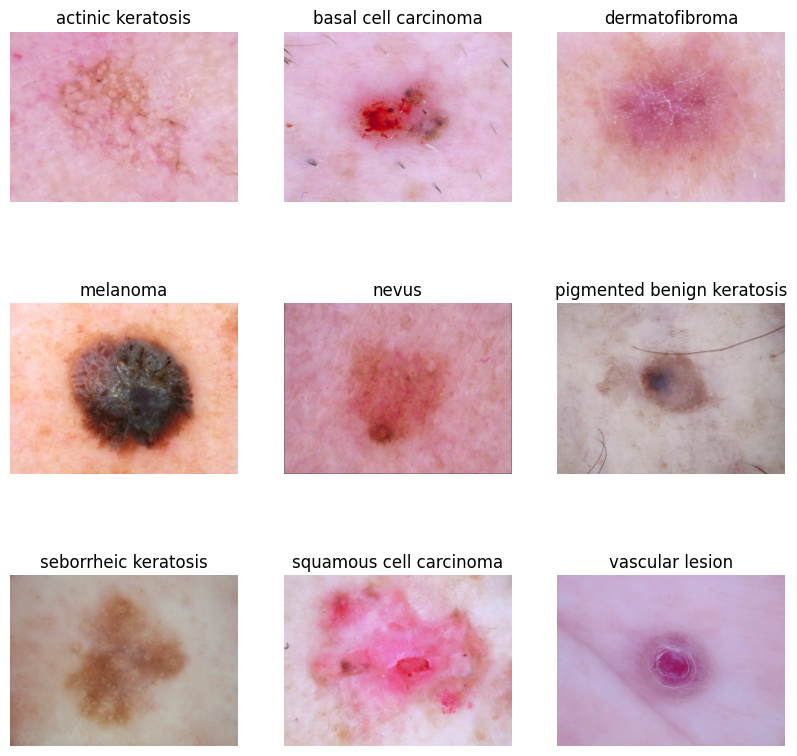

In [9]:
# Visualizing the images using train data
# Create a 3x3 grid of subplots within a larger figure
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  # Read the second image file for each class and convert it to an array
  image = plt.imread(str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

#### The dataset:
The `**image_batch**` contains 32 images, each sized 180x180 pixels with RGB color channels. The `**label_batch**` comprises 32 corresponding labels identifying the category of each image, forming a dataset for model training.

### Optimizing data loading and processing for model building and training
Caching and prefetching the data improves the efficiency of data loading and processing during model training.

In [10]:
# Set the AUTOTUNE parameter to the experimental AUTOTUNE value from the tf.data module
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Cache the training dataset, shuffle it with a buffer size of 1000, and prefetch elements using the AUTOTUNE buffer size
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Cache the validation dataset and prefetch elements using the AUTOTUNE buffer size
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model building & traing: 1st attempt

#### Model Building

In [11]:
## Creating a CNN model with 3 convolution layers along with maxpooling, dense layer with 128 neurons

# Initialize the Sequential model
model = Sequential()
# Rescale input data to range [0,1] and define input shape
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
# Add convolutional layers along and applying max pooling to reduce spatial dimensions
model.add(Conv2D(16, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2,2)))
# Flatten the feature maps to feed into fully connected layers
model.add(Flatten())
# Add a fully connected layer with 128 neurons and ReLU activation function
model.add(Dense(128,activation='relu'))
# Add the output layer with 9 neurons (one for each class) and softmax activation function for multi-class classification
model.add(Dense(9,activation='softmax'))

### Compiling the model

In [12]:
# Compile the model with the Adam optimizer
# Using SparseCategoricalCrossentropy as the loss function, setting from_logits=True
# Accuracy metric to track during training
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Model Training

In [14]:
## Setting the epoch to 20 to train the dataset
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 509s 2s/step - loss: 2.2723 - accuracy: 0.2083 - val_loss: 2.0305 - val_accuracy: 0.1492
Epoch 2/20
57/57 [==============================] - 1s 21ms/step - loss: 1.9818 - accuracy: 0.2367 - val_loss: 1.8375 - val_accuracy: 0.3363
Epoch 3/20
57/57 [==============================] - 1s 22ms/step - loss: 1.8330 - accuracy: 0.3228 - val_loss: 1.8017 - val_accuracy: 0.3363
Epoch 4/20
57/57 [==============================] - 1s 21ms/step - loss: 1.6999 - accuracy: 0.3861 - val_loss: 1.7544 - val_accuracy: 0.3608
Epoch 5/20
57/57 [==============================] - 1s 22ms/step - loss: 1.5606 - accuracy: 0.4433 - val_loss: 1.5410 - val_accuracy: 0.4588
Epoch 6/20
57/57 [==============================] - 1s 20ms/step - loss: 1.4469 - accuracy: 0.4906 - val_loss: 1.4603 - val_accuracy: 0.4900
Epoch 7/20
57/57 [==============================] - 1s 20ms/step - loss: 1.3561 - accuracy: 0.5333 - val_loss: 1.5311 - val_accuracy: 0.4477
Epoch 8/20
57

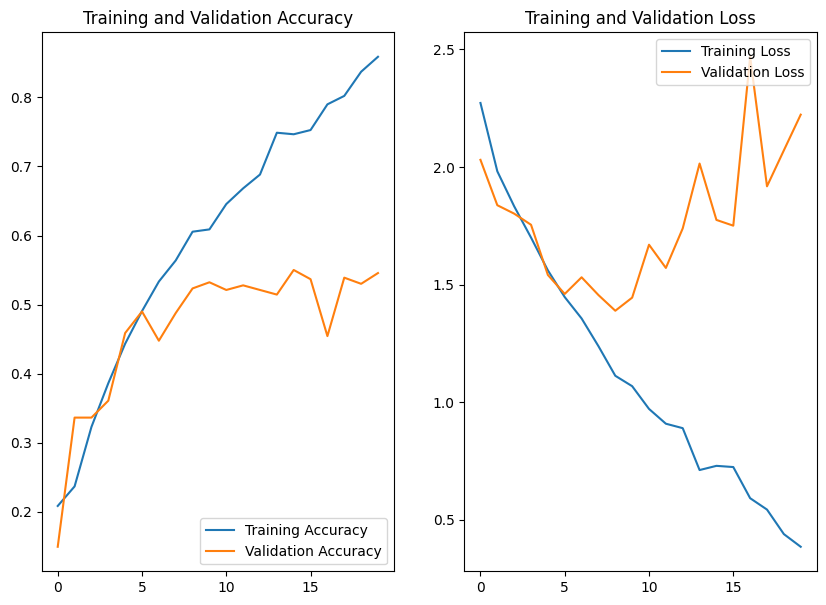

In [15]:
## Ploting the train vs validation accuracy & train vs validation loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### <font color= Red>Findings:</font>
- The training accuracy is high whereas the validation accuracy is very low which indicate overfitting.
- Similarly the validation loss is going up while the training loss is going down in keeping with the results for the training and validation accuracy.

###

## Data augmentation to resolve overfitting

The entire `data_augmentation` pipeline consists of a series of image augmentation operations that can be applied to input images to increase the diversity of the training data and improve the generalization of the model. The augmentations to be applied are: horizontal flipping, random rotation, random zoom and random contrast.

In [16]:
# Data augmentation pipeline using Sequential model
data_augmentation = keras.Sequential([
    # Randomly flip the input images horizontally
    layers.RandomFlip("horizontal"),
    # Randomly rotate the input images by a maximum of 0.1 radians
    layers.RandomRotation(0.1),
    # Randomly zoom into the input images by a maximum of 10%
    layers.RandomZoom(0.1),
    # Randomly adjust the brightness of the input images by a maximum of 0.1
    layers.RandomContrast(0.1)
])

2024-04-09 15:44:01.881697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


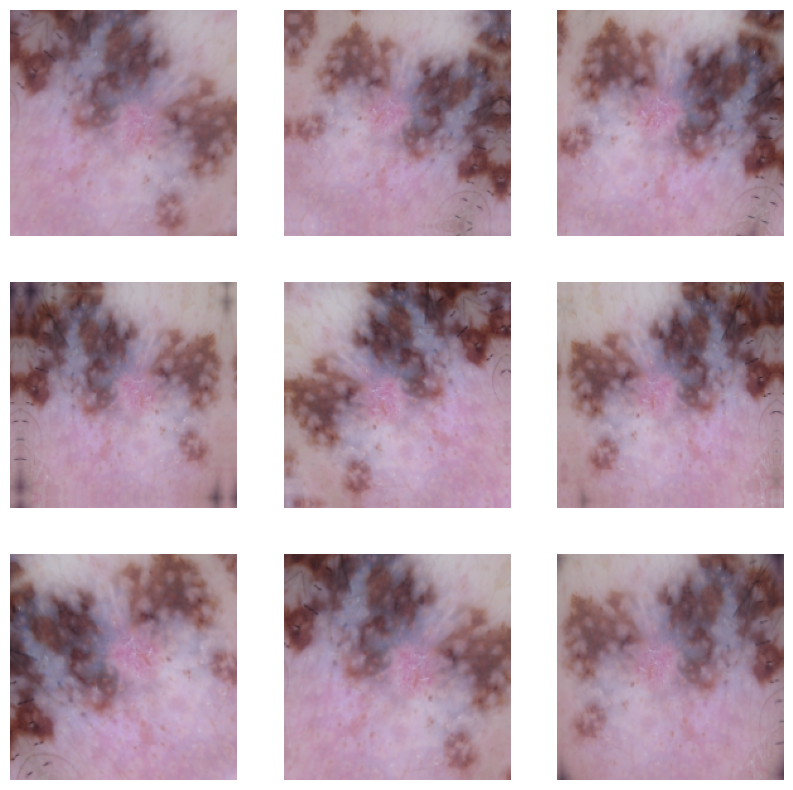

In [ ]:
## Visualize part of the augmented images from training data
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Model building and training on augmented data- 2nd attempt
This time we build a model by adding augmentation and dropout layers plus more conv layers

In [ ]:
## Model 2: Define a CNN model with data augmentation

# Initialize the Sequential model
model = Sequential()

# Rescale input data to range [0,1] and define input shape
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))

# Apply data augmentation to increase dataset diversity and reduce overfitting
model.add(data_augmentation)
# Add convolutional layers along and applying max pooling to reduce spatial dimensions and dropout regularization to prevent overfitting
model.add(Conv2D(32, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Flatten the feature maps to feed into fully connected layers
model.add(Flatten())
# Add a fully connected layer with 128 neurons and ReLU activation function
model.add(Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
# Add the output layer with 9 neurons (one for each class) and softmax activation function for multi-class classification
model.add(Dense(9, activation='softmax'))

### Compile Model 2

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train model 2

In [ ]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.1615 - loss: 3.7632 - val_accuracy: 0.1499 - val_loss: 2.0932
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.2042 - loss: 2.0375 - val_accuracy: 0.3758 - val_loss: 1.9768
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.3115 - loss: 1.9138 - val_accuracy: 0.4027 - val_loss: 1.9305
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.3432 - loss: 1.8193 - val_accuracy: 0.4362 - val_loss: 1.6685
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.4238 - loss: 1.6861 - val_accuracy: 0.4676 - val_loss: 1.6257
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.4425 - loss: 1.5611 - val_accuracy: 0.4989 - val_loss: 1.5707
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.4361 - loss: 1.5781 - val_accuracy: 0.4944 - val_loss: 1.5038
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.4814 - loss: 1.4731 - val_accuracy: 0.4318

### Visulaize the results

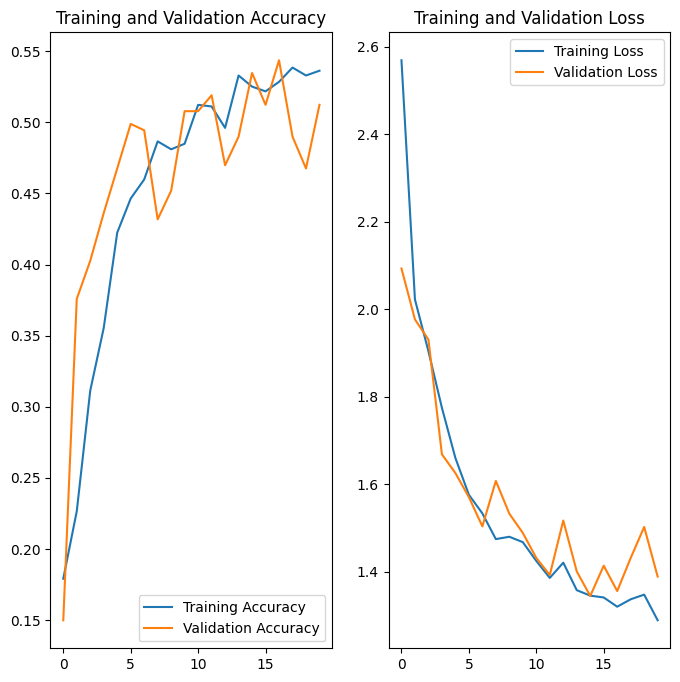

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### <font color= red>Findings:</font>
- We can clearly see that the overfitting has beeen resolved after adding the data augmentation layer, the dropout layers and additional convolutional layers.
- However, we also observe a decline in the training accuracy we could be due to the presence of class imbalance in the dataset.

## Class Distribution
We will now examine the class distribution in training dataset

In [ ]:
### Counting the number of images in each class
# Create an empty list to store dictionaries
class_diff_data = []

# Iterate through each class name
for name in class_names:
    number = len(list(data_dir_train.glob(f'{name}/*.jpg')))  # Count the number of images in the class
    # Append the class name and the number of images as a dictionary to the list
    class_diff_data.append({'class': name, 'number': number})

# Create a DataFrame from the list of dictionaries
class_diff = pd.DataFrame(class_diff_data)

# Display the DataFrame containing class names and the number of images in each class
class_diff

,class,number
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<function matplotlib.pyplot.show(close=None, block=None)>

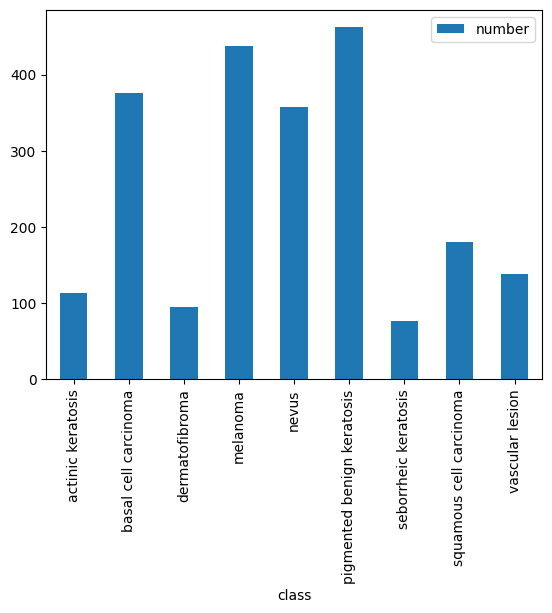

In [ ]:
## Bar plots of the class distribution
class_diff.plot.bar(x='class',y='number',rot=90)
plt.show

### <font color= red>Findings:</font>

- Seborrheic keratosis (77) has the least number of samples.
- Pigmented benign keratosis (462), melanoma (438), basal cell carcinoma (376), and nevus (357) dominate the data in terms of proportionate number of samples in the data respectively.
- As evident, there is definitely a class imbalance present the dataset which should be handled and as a result could potentially improve the predictive power of the model.

## Handling Class imbalances

In [30]:
## Number of images in the original dataset
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2249

In [ ]:
## Creating dataframe with the path and label for the orginal dataset
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/deep learning/Skin can...,pigmented benign keratosis
1,/content/gdrive/MyDrive/deep learning/Skin can...,pigmented benign keratosis
2,/content/gdrive/MyDrive/deep learning/Skin can...,pigmented benign keratosis
3,/content/gdrive/MyDrive/deep learning/Skin can...,pigmented benign keratosis
4,/content/gdrive/MyDrive/deep learning/Skin can...,pigmented benign keratosis
...,...,...
2234,/content/gdrive/MyDrive/deep learning/Skin can...,nevus
2235,/content/gdrive/MyDrive/deep learning/Skin can...,nevus
2236,/content/gdrive/MyDrive/deep learning/Skin can...,nevus
2237,/content/gdrive/MyDrive/deep learning/Skin can...,nevus


In [ ]:
## Number of sdample in the original dataset before generation of augmented images
original_df['Label'].value_counts()

Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

#### `**Class imbalance handling approach**`:
We are using a python package called Augmentor to generate and add more samples across the classes so that none of the classes will have too little samples to off-set the balance of the dataset. Augmentor generates more images after stochastically augmenting them with operations like rotation, cropping, etc.

In [17]:
!pip install Augmentor

In [18]:
# Iterate through each class
import Augmentor
path_to_training_dataset=data_dir_train

for class_name in class_names:
    p = Augmentor.Pipeline((path_to_training_dataset / class_name).as_posix())
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep learning/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B6ED81A6710>: 100%|██████████| 500/500 [00:20<00:00, 23.81 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep learning/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B6EC076BB50>: 100%|██████████| 500/500 [00:24<00:00, 20.69 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep learning/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B6ED80E79D0>: 100%|██████████| 500/500 [00:19<00:00, 25.96 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep learning/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7B6EC07321D0>: 100%|██████████| 500/500 [01:23<00:00,  5.97 Samples/s]


Initialised with 367 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep learning/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7B6EC07B2FE0>: 100%|██████████| 500/500 [01:16<00:00,  6.50 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep learning/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B6EDC619FC0>: 100%|██████████| 500/500 [00:18<00:00, 27.05 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep learning/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7B6ED8741030>: 100%|██████████| 500/500 [00:41<00:00, 11.91 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep learning/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B6ED8370BE0>: 100%|██████████| 500/500 [00:17<00:00, 28.01 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep learning/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B6EE47BD840>: 100%|██████████| 500/500 [00:20<00:00, 24.92 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. We will now take a look at total count of augmented images.

In [8]:
## Calculating the total count of augmented images
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Distribution of augmented data after adding new images to the original training data.

In [ ]:
## Creating a new list containg the path for the newly generated images using augmentor
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/deep learning/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027239.jpg_d8a03663-66f7-49f3-bf77-bd129d023eaf.jpg',
 '/content/gdrive/MyDrive/deep learning/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027192.jpg_f3074cb4-bd3c-4b8c-bf69-1097525e0251.jpg',
 '/content/gdrive/MyDrive/deep learning/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026871.jpg_11034af4-1d3d-4e61-953f-3d946dd9b38d.jpg',
 '/content/gdrive/MyDrive/deep learning/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026298.jpg_bc43a687-9e2b-49a0-af41-a28dc11f99d0.jpg',
 '/content/gdrive/MyDrive/deep learning/Skin can

In [ ]:
## Creating a list containing all the labels of the diseases for the newly generated images
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
## Creating a dataframe df2 containing the path and label of all the augmented images generated
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# Concatenating df2 to original_df
new_df = pd.concat([original_df, df2], ignore_index=True)

In [ ]:
## Value count of the number of samples in the dataset for each diseases
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

### <font color= red>Observation:</font>
- We can clearly see that after using the Augmentor which generated 500 augmented images of each class, there is no class imbalance. Each of the 9 classes have at least 500 plus samples.

## Final Model building & training
On the dataset after class imbalances have been resolved

In [9]:
## Parameters for the dataset
batch_size = 32
img_height = 180
img_width = 180

In [10]:
## Training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


In [11]:
## Validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
### Final Model
model = Sequential()

# Rescaling the 1st layer
model.add(layers.Rescaling(1./255,input_shape=(img_height, img_width,3)))
# Add convolutional layers along and applying max pooling to reduce spatial dimensions and dropout regularization to prevent overfitting
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
# Flatten the feature maps to feed into fully connected layers
model.add(layers.Flatten())
# Add a fully connected layers with 256, 128 and 64 neurons and ReLU activation function
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
# Add the output layer with 9 neurons (one for each class) and softmax activation function for multi-class classification
model.add(layers.Dense(9,activation='softmax'))

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

In [16]:
## Training the final model for 30 epochs
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 1567s 2s/step - loss: 2.1281 - accuracy: 0.1759 - val_loss: 1.9116 - val_accuracy: 0.2172
Epoch 2/30
169/169 [==============================] - 10s 60ms/step - loss: 1.8759 - accuracy: 0.2569 - val_loss: 1.7760 - val_accuracy: 0.3403
Epoch 3/30
169/169 [==============================] - 10s 59ms/step - loss: 1.6833 - accuracy: 0.3494 - val_loss: 1.6175 - val_accuracy: 0.3929
Epoch 4/30
169/169 [==============================] - 10s 59ms/step - loss: 1.5588 - accuracy: 0.4007 - val_loss: 1.4120 - val_accuracy: 0.4351
Epoch 5/30
169/169 [==============================] - 10s 60ms/step - loss: 1.4918 - accuracy: 0.4178 - val_loss: 1.4137 - val_accuracy: 0.4566
Epoch 6/30
169/169 [==============================] - 10s 59ms/step - loss: 1.4546 - accuracy: 0.4365 - val_loss: 1.3455 - val_accuracy: 0.4781
Epoch 7/30
169/169 [==============================] - 10s 59ms/step - loss: 1.4159 - accuracy: 0.4381 - val_loss: 1.3013 - val_accuracy:

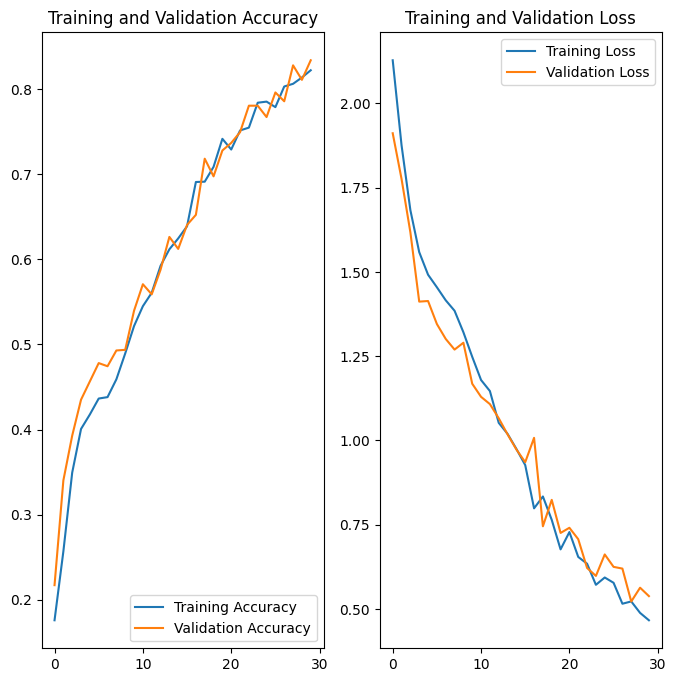

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### <font color= red>Findings:</font>
- As a result of rectifying the dataset of class imbalances, adding dropout layers and appropriate convolution layers, the final model produces good training and validation accuracy scores. Likewise for the traing and validation accuracy.
- Looking at the raining and validation accuracy and loss values, it seems that the model is performing well without significant signs of overfitting or underfitting. Both the training and validation accuracies are gradually increasing, while the loss values are decreasing, indicating that the model is learning effectively from the data. Additionally, the validation accuracy is close to the training accuracy, suggesting that the model generalizes well to unseen data, which is another indicator of good performance. Therefore, it appears that this CNN model is appropriately fitting the data without overfitting or underfitting.

## Model Testing
let's check out the predictive ability of the final model

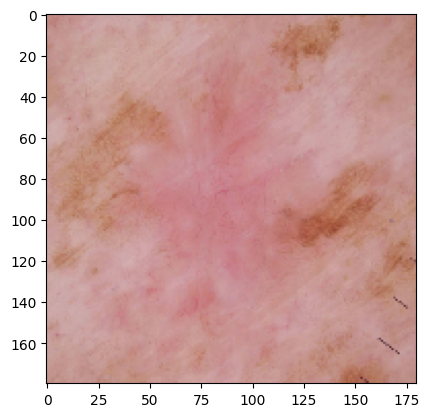

1/1 [==============================] - 0s 473ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


In [18]:
# Get a list of paths for all images in the test dataset for a specific class
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)

# Randomly select an image from the list
selected_image_path = np.random.choice(Test_image)

# Load the selected image, resize it to match the input size of your model (180x180), and plot it
Test_image = load_img(selected_image_path, target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)
plt.show()

# Preprocess the image for prediction
img = np.expand_dims(Test_image,axis=0)

# Make predictions using the model
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]

# Print the actual and predicted classes
actual_class = class_names[1]  # Assuming class_names[1] is the correct class
print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {pred_class}")

### <font color= red>Conclusion:</font>
- The final model successfully predicted the class of the image from the test set.
- So we can confidently say that we have a robust CNN model that can be used for melanoma detection.  